Ονομ/νυμο: **Βασιλική Παπαγεοεργίου** ΑΜ: **03116673** 

# 3η Εργασία: Βαθιά Μάθηση

Θέμα της 3ης εργασίας του μαθήματος είναι η Βαθιά Μάθηση. Θα μελετήσουμε ένα πρόβλημα που συνδυάζει Όραση Υπολογιστών και Επεξεργασία Φυσικής Γλώσσας. Συγκεκριμένα, θα φτιάξουμε ένα νευρωνικό δίκτυο παραγωγής λεκτικών περιγραφών από εικόνες (Image Captioning).

In [ ]:
import tensorflow as tf

# You'll generate plots of attention in order to see which parts of an image
# your model focuses on during captioning
import matplotlib.pyplot as plt

import collections
import random
import numpy as np
import pandas as pd
import os
import io
import time
import json
from PIL import Image
import joblib

import keras
import nltk
nltk.download('punkt') 
from collections import Counter

!pip install tqdm
from tqdm import tqdm

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
from google.colab import drive
drive.mount('/content/drive') 

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Σύνολο δεδομένων
Τα ευρύτερα χρησιμοποιούμενα datasets στο Image Captioning είναι τα Flickr8k, Flickr30k, και το COCO. Το παράδειγμα του TensorFlow χρησιμοποιεί το COCO. Εμείς θα χρησιμοποιήσουμε το "flickr30k-images-ecemod", μια παραλλαγή του flick30k για το μάθημά μας.

Τα δεδομένα του flickr30k-images-ecemod είναι τα εξής:

* ένας φάκελος "image_dir" με 31.783 εικόνες από το Flickr
* ένα αρχείο "train_captions.csv" με 148.915 captions για τις εικόνες του "image_dir"
* ένα αρχείο "test_images.csv" με 2.000 ονόματα εικόνων από το "imag_dir" που δεν 
* έχουν captions εκπαίδευσης

Στα επόμενα κελιά κατεβάζουμε τα δεδομένα του dataset:

In [ ]:
## dataset

# Download image files
image_zip = tf.keras.utils.get_file('flickr30k-images-ecemod.zip',
                                      cache_subdir=os.path.abspath('.'),
                                      origin='https://www.dropbox.com/s/efqe8131slq1zah/flickr30k-images-ecemod.zip?dl=1',
                                      extract=True)
os.remove(image_zip)

4376395776/4376381805 [==============================] - 200s 0us/step


In [ ]:

## train-test

# Download train captions file
train_captions_file = tf.keras.utils.get_file('train_captions.csv',
                                           cache_subdir=os.path.abspath('.'),
                                           origin='https://www.dropbox.com/s/qqrsitwecf7fjd3/train_captions.csv?dl=1',
                                           extract=False)

12500992/12484775 [==============================] - 2s 0us/step


### Embeddings glove.6b

Ψάχνοντας για το glove.6b από το nlp.stanford.edu παρατηρούμε πως περιέχει τα embeddings glove-wiki οπότε μπορούμε να το χρησιμοποιήσουμε. 

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

In [ ]:
data_path = keras.utils.get_file(
    "news20.tar.gz",
    "http://www.cs.cmu.edu/afs/cs.cmu.edu/project/theo-20/www/data/news20.tar.gz",
    untar=True,
)

17342464/17329808 [==============================] - 18s 1us/step


In [ ]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip -q glove.6B.zip

--2022-03-13 07:12:00--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2022-03-13 07:12:00--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2022-03-13 07:12:01--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6

In [ ]:
# downloaded database
train_captions = pd.read_csv(train_captions_file ,header= None, sep = '|')
#test_images = pd.read_csv(test_images_file ,header= None)


## Προεπεξεργασία κειμένου
1. Τα captions έχουν διαφορετικά μήκη. Τα πολύ σύντομα και τα πολύ μεγάλα δεν είναι χρήσιμα στην εκπαίδευση. Στο tutorial χρησιμοποιείται ad-hoc ένα μέγιστο μήκος 50 λέξεων. Φιλτράρετε το dataset έτσι ώστε να έχετε ένα range από 25 έως 35 διαφορετικά μήκη, χωρίς ούτε τα πολύ μικρά και χωρίς ούτε τα πολύ μεγάλα (δοκιμάστε ένα ιστόγραμμα).
2. Η συνάρτηση standardize θα μπορούσε να περιλαμβάνει και μερικά φίλτρα ακόμα κανονικοποίησης.
3. To tutorial αποφασίζει ad hoc για ένα vocabulary 5000 λέξεων. Δοκιμάσαμε κάποια διαφορετικά (μεγαλύτερα) μεγέθη vocabulary όπως 7.000 και 10.000.

 Two men with a wheelbarrow on a closed sidewalk , indicated by a sign .
 Two construction workers are working on the road .
 Two men are working on the curb of a street .
 A man cleans up trash on a sidewalk .
 Two men work on a parking lot .


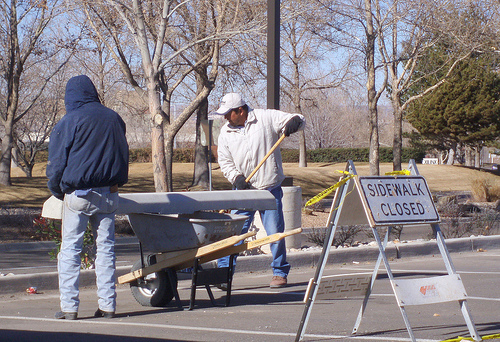

In [ ]:
# Βλέπουμε μία αναπαράσταση από τα 5 captions που αντιστοιχούμε στην συγκεκριμένη(i-οστή) εικόνα. 
# Με αυτόν τον τροπο ελέγχουμε την μορφή των δεδομένων και αν έχουμε πρόσβαση σε αυτά μετά την μεταφόρτωση. 
i=108
[print(cap) for cap in train_captions[2][5*i:5*i+5]]
Image.open('./image_dir/'+train_captions[0][i*5])

### train_caption format
Από τα δεδομένα που αποθηκεύσαμε θέλουμε να κρατήσουμε caption και εικόνες σε ένα dictionary με κλειδιά τη διεύθυνση της εικόνας (για οικονομία χώρου, να μην αντιγράφουμε ολόκληρη την εικόνα). 
Σε κάθε caption προσθέτουμε ένα πρόθεμα <start>` και `<end>` για να μπορεί να τα επεξεργαστεί το μοντέλο. 

In [ ]:
PATH = '/content/image_dir/'

# Group all captions together having the same image ID.
image_path_to_caption = collections.defaultdict(list)
for i in range(len(train_captions)):
  caption = f"<start> {train_captions[2][i]} <end>"
  image_path = PATH + train_captions[0][i]
  image_path_to_caption[image_path].append(caption)

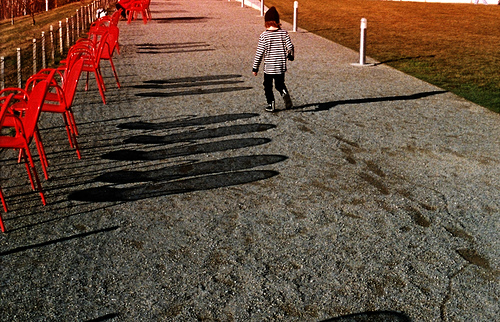

In [ ]:
Image.open('./image_dir/_100007487.jpg')

Για λόγους ευκολίας μειώνουμε το dataset και μαλλον κατα την τελική εκπαίδευση θα πάρουμε όλα τα δεδομένα.

In [ ]:
image_paths = list(image_path_to_caption.keys())
random.shuffle(image_paths)

# Select the first 6000 image_paths from the shuffled set.
# Approximately each image id has 5 captions associated with it, so that will
# lead to 30,000 examples.
train_image_paths = image_paths
print(len(train_image_paths))

29782


Φτιάχνουμε 2 λίστες που η καθεμία στην i-οστή θεση έχουν caption και διεύθυνση εικόνας εντίστοιχα. 

In [ ]:
train_caps = []
img_vect = []
for image_path in train_image_paths:
  caption_list = image_path_to_caption[image_path]
  train_caps.extend(caption_list)
  img_vect.extend([image_path] * len(caption_list))   # Στο παραδειγμά μας είναι πάντα 5 το len(caption_list)

In [ ]:
len(train_caps)

148915

<start>  A guy in a hard hat working on some machines . <end>


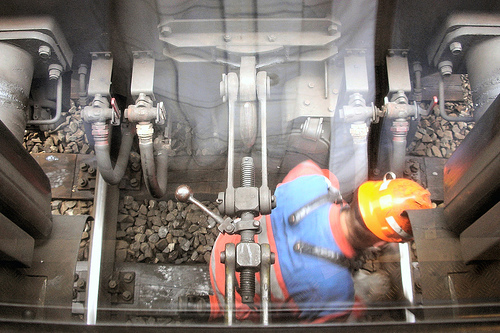

In [ ]:
print(train_caps[457])
Image.open(img_vect[457])

#### Τα captions έχουν διαφορετικά μήκη. 
Τα πολύ σύντομα και τα πολύ μεγάλα δεν είναι χρήσιμα στην εκπαίδευση. Στο tutorial χρησιμοποιείται ad-hoc ένα μέγιστο μήκος 50 λέξεων. Φιλτράρουμε το dataset έτσι ώστε να έχετε ένα range από 25 έως 35 διαφορετικά μήκη, χωρίς ούτε τα πολύ μικρά και χωρίς ούτε τα πολύ μεγάλα. 


In [ ]:
from nltk.tokenize import word_tokenize
# Μετρλησαμε το μήκος της ελάχιστης επιγραφής για να μην επηρεάζει το πρόθεμα-επίθεμα
minlength = "<start>  <end>"
print("The minimum length is " , len(word_tokenize(minlength)))

# Words in captions 
# Τα μετράμε και τα βάζουμε σε έναν πίνακα για να γίνει το plot. Αφαιρουμε 6 για να μην μετράμε το "minimum length" 
words = []
for cap in train_caps:
    words.append(len(word_tokenize(cap))-6)
print("Captions:\n", len(words))


The minimum length is  6
Captions:
 148915


The mean number of words in a caption is:  13.390450928381963


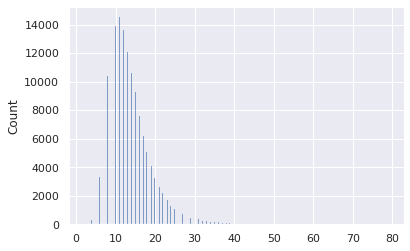

In [ ]:
# Plot ( number of words per caption )
import seaborn as sns
import matplotlib.pyplot as plt

print("The mean number of words in a caption is: ", np.mean(words))
# set a grey background (use sns.set_theme() if seaborn version 0.11.0 or above) 
sns.set(style="darkgrid")
sns
sns.histplot(data=words)
plt.show()

Άρα θα χρειαστεί να κόψουμε/διαγράψουμε κάθε caption που έχει λιγότερες από 4 λέξεις και περισσότερες από 30. 


In [ ]:
train_captions = []
img_name_vector = []

w = 0 
for i in range(len(train_caps)):
  w = len(word_tokenize(train_caps[i]))-6
  if w>3 and w<31: 
    train_captions.append(train_caps[i])
    img_name_vector.append(img_vect[i])

Words in captions:
 146992
The mean number of words in a caption is:  13.103604277783825


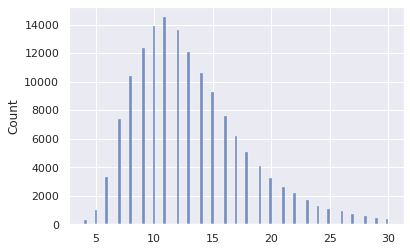

In [ ]:
# Words in captions
# Τσεκάρουμε την κατανομή αφού κόψαμε τα outliers
words = []
for cap in train_captions:
    words.append(len(word_tokenize(cap))-6)
print("Words in captions:\n", len(words))

print("The mean number of words in a caption is: ", np.mean(words))
# set a grey background (use sns.set_theme() if seaborn version 0.11.0 or above) 
sns.set(style="darkgrid")
sns
sns.histplot(data=words)
plt.show()

<start>  A hippie couple is walking through the city , bag od KFC in hand . <end>


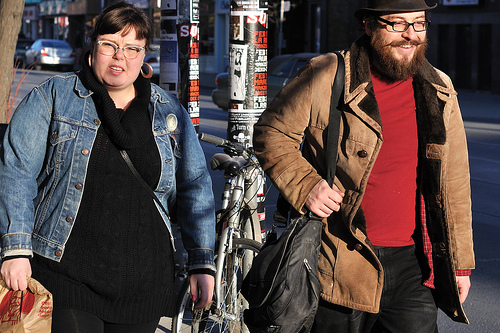

In [ ]:
# edw Ελέγχουμε την αναπαρασταση και αν ταιριάζουν caption-εικόνες
print(train_captions[988])
Image.open(img_name_vector[988])

## Preprocess and tokenize the captions

Θα μετατρέψουμε τις περιγραφες κειμένου σε ακολουθίες ακέραιων αριθμών χρησιμοποιώντας το [TextVectorization](https://www.tensorflow.org/api_docs/python/tf/keras/layers/TextVectorization), με τα ακόλουθα βήματα:

* Χρησιμοποιούμε το [adapt](https://www.tensorflow.org/api_docs/python/tf/keras/layers/TextVectorization#adapt) για να κάνουμε iterate όλα τα captions, να τα χωρίσουμε σε λέξεις και να υπολογίσουμε το λεξιλόγιο των κορυφαίων 7.000 ή 10.000 λέξεις (για εξοικονόμηση μνήμης).
* Κάνουμε Tokenize όλα τα captions και mapping κάθε λέξη στο index του λεξικού. Όλες οι ακολουθίες εξόδου θα συμπληρωθούν σε μήκος 30 όπως το έχουμε αποφασίσει νωρίτερα βάση του βέλτιστου μήκους caption.
* Δημιουργoύμε αντιστοιχίσεις word-to-index and index-to-word για την εμφάνιση αποτελεσμάτων

Η συνάρτηση standardize θα μπορούσε να περιλαμβάνει και μερικά φίλτρα ακόμα κανονικοποίησης. Προσοχή εδώ δεν κάνουμε stemming.


In [ ]:
caption_dataset = tf.data.Dataset.from_tensor_slices(train_captions)

# We will override the default standardization of TextVectorization to preserve
# "<>" characters, so we preserve the tokens for the <start> and <end>.
def standardize(inputs):
  inputs = tf.strings.lower(inputs)
  return tf.strings.regex_replace(inputs,
                                  r"!\"#$%&\(\)\*\+.,-/:;=?@\[\\\]^_`{|}~", "")


In [ ]:
# Max word count for a caption.  
max_length = 30

# Use the top 6000 words for a vocabulary.
vocabulary_size = 10000 
tokenizer = tf.keras.layers.TextVectorization(
    max_tokens=vocabulary_size,
    standardize=standardize,
    output_sequence_length=max_length)
# Learn the vocabulary from the caption data.
tokenizer.adapt(caption_dataset)

In [ ]:
# Create the tokenized vectors
cap_vector = caption_dataset.map(lambda x: tokenizer(x))

In [ ]:
# Create mappings for words to indices and indicies to words.
word_to_index = tf.keras.layers.StringLookup(
    mask_token="",
    vocabulary=tokenizer.get_vocabulary())
index_to_word = tf.keras.layers.StringLookup(
    mask_token="",
    vocabulary=tokenizer.get_vocabulary(),
    invert=True)

## Embeddings
Τα word embeddings είναι μια εκμαθημένη αναπαράσταση για κείμενο όπου λέξεις που έχουν την ίδια σημασία έχουν παρόμοια αναπαράσταση. Είναι αυτή η προσέγγιση για την αναπαράσταση λέξεων και εγγράφων που μπορεί να θεωρηθεί μία από τις βασικές ανακαλύψεις της βαθιάς μάθησης σε προκλητικά προβλήματα επεξεργασίας φυσικής γλώσσας.

Έχουμε αποθηκεύσει στην μνήμη glove embeddings με διάφορα diamensions. 
Φορτώνουμε αυτό που μας φέρνει τα καλύτερα αποτελέσματα. 

Κι έπειτα φτιάχνουμε ένα dict για να κάνουμε mapping words (strings) σε NumPy vector representation:




In [ ]:
embeddings_index = {}
embedding_dim = 200
with open('/content/glove.6B.200d.txt') as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs

print("Found %s word vectors." % len(embeddings_index))

Found 400000 word vectors.


In [ ]:
# Ετσι δουλευει το tokenizer
output = tokenizer([["Two blond women are posing in front of the camera with a large green toy"]])
output.numpy()

array([[ 16, 158,  49,  17, 256,   6,  42,  12,   7, 102,  13,   2,  58,
         51, 220,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0]])

Εδώ περνάμε όλο το λεξιλόγιο που πήραμε από το tokenizer σε μία λίστα και μετά αριθμούμε διαδοχικά τις λέξεις. Αυτό θα μας βοηθήσει στην αντιστοίχηση των λέξεων στα embeddings με αυτές που πράγματι υπάρχουν στο δικό μας λεξιλόγιο. Επίσης εμεις έχουμε 7.000 -10.000 λέξεις ενώ το glove6B περιέχει coefficients για 400.000. 

In [ ]:
voc = tokenizer.get_vocabulary()
word_index = dict(zip(voc, range(len(voc))))

Τώρα, ας ετοιμάσουμε ενα αντίστοιχο embedding matrix που μπορούμε να χρησιμοποιήσουμε σε ένα Keras embedding layer. Είναι ένας απλός πίνακας NumPy όπου η καταχώριση στο δείκτη i είναι το προ-εκπαιδευμένο διάνυσμα για τη λέξη του ευρετηρίου i στο vocabulary του vectorizer μας.

In [ ]:
num_tokens = len(voc) + 2
#embedding_dim = 100
hits = 0
misses = 0

# Prepare embedding matrix
embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        # This includes the representation for "padding" and "OOV"
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
print("Converted %d words (%d misses)" % (hits, misses))

Converted 9809 words (191 misses)


## Προεπεξεργασία εικόνων χρησιμοποιώντας το μοντέλο NASNetLarge

Στη συνέχεια, θα χρησιμοποιήσετε το NASNetLarge (το οποίο είναι προεκπαιδευμένο στο Imagenet) για να ταξινομήσετε κάθε εικόνα. 

* Θα εξαγάγετε χαρακτηριστικά από το τελευταίο συνελικτικό επίπεδο.

* [Προεπεξεργαζόμαστε τις εικόνες](https://cloud.google.com/tpu/docs/inception-v3-advanced#preprocessing_stage) χρησιμοποιώντας [preprocess_input](https://www.tensorflow.org/api_docs/python/tf/keras/applications/nasnet/NASNetLarge) κανονικοποίηση στην εικόνα έτσι ώστε να περιέχει pixel στην περιοχή από -1 έως 1, η οποία ταιριάζει με τη μορφή των εικόνων που χρησιμοποιούνται για την εκπαίδευση του NASNetLarge.

In [ ]:
def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.io.decode_jpeg(img, channels=3)
    img = tf.keras.layers.Resizing(331, 331)(img)
    img = tf.keras.applications.nasnet.preprocess_input(img)
    return img, image_path

### Αρχικοποιούμε το NASNetLarge και φορτώνουμε τα προ-εκπαιδευμένα Imagenet βάρη.

Τώρα θα δημιουργήσυμε ένα μοντέλο tf.keras όπου το output layer είναι το τελευταίο συνελικτικό επίπεδο στην αρχιτεκτονική NASNetLarge. Το σχήμα της εξόδου αυτού του επιπέδου είναι "11x11x4032". Χρησιμοποιούμε το τελευταίο συνελικτικό επίπεδο επειδή χρησιμοποιούμε τον μηχανισμό attention σε αυτό το παράδειγμα. Δεν εκτελούμε αυτήν την προετοιμασία κατά τη διάρκεια της εκπαίδευσης γιατί θα μπορούσε να δημιουργήσει bottleneck.


* Προωθούμε κάθε εικόνα μέσω του δικτύου και αποθηκεύουμε το διάνυσμα που προκύπτει σε ένα λεξικό (image_name --> feature_vector).
* Αφού περάσουν όλες οι εικόνες μέσω του δικτύου, αποθηκεύουμε το vocabulary στο δίσκο.

In [ ]:
image_model = tf.keras.applications.NASNetLarge(include_top=False,
                                                weights='imagenet')
new_input = image_model.input
hidden_layer = image_model.layers[-1].output

image_features_extract_model = tf.keras.Model(new_input, hidden_layer)

343621632/343610240 [==============================] - 5s 0us/step


### Αποθήκευση των features που εξάγονται από το NASNetLarge

Θα προεπεξεργαζόμαστε κάθε εικόνα με το NASNetLarge και θα αποθηκεύουμε προσωρινά την έξοδο στο δίσκο. Η προσωρινή αποθήκευση της εξόδου στη μνήμη RAM θα ​​ήταν ταχύτερη αλλά memory intensive, απαιτώντας 11 \* 11 \* 4032 floats per image. Τη στιγμή της γραφής, αυτό υπερβαίνει τους περιορισμούς μνήμης του Colab (επί του παρόντος 12 GB μνήμης).

Η απόδοση θα μπορούσε να βελτιωθεί με μια πιο εξελιγμένη στρατηγική αποθήκευσης στην κρυφή μνήμη (για παράδειγμα, με κοινή χρήση των εικόνων για τη μείωση του  random access disk I/O), αλλά αυτό θα απαιτούσε περισσότερο κώδικα.

Η προσωρινή αποθήκευση θα διαρκέσει περίπου 10 λεπτά για να εκτελεστεί στο Colab με GPU.


1. Install [tqdm](https://github.com/tqdm/tqdm):

    `!pip install tqdm`

2. Import tqdm:

    `from tqdm import tqdm`

3. Change the following line:

    `for img, path in image_dataset:`

    to:

    `for img, path in tqdm(image_dataset):`


In [ ]:
# Get unique images
encode_train = sorted(set(img_name_vector))

# Feel free to change batch_size according to your system configuration
image_dataset = tf.data.Dataset.from_tensor_slices(encode_train)
image_dataset = image_dataset.map(
  load_image, num_parallel_calls=tf.data.AUTOTUNE).batch(16)

for img, path in tqdm(image_dataset):
  batch_features = image_features_extract_model(img)
  batch_features = tf.reshape(batch_features,
                              (batch_features.shape[0], -1, batch_features.shape[3]))

  for bf, p in zip(batch_features, path):
    path_of_feature = p.numpy().decode("utf-8")
    np.save(path_of_feature, bf.numpy())

100%|██████████| 1862/1862 [14:48<00:00,  2.10it/s]


Από τον πίνακα bf καταφέραμε να αποφασίσουμε και το σχήμα των features. 

In [ ]:
bf

<tf.Tensor: shape=(121, 4032), dtype=float32, numpy=
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)>

## Καποια θεωρια 


<h1>Το μοντέλο </h1> 
Το μοντέλο του tutorial ακολουθεί την συνήθη αρχιτεκτονική στη Βαθιά Μάθηση του Encoder - Decoder.

Encoder: ένα pretrained συνελικτικό λαμβάνει ως είσοδο την εικόνα (1). Η μεταφορά μάθησης γίνεται χωρίς το classification head. Μας ενδιαφέρει μόνο η έξοδος που δίνουν για την εικόνα τα ανώτερα συνελικτικά επίπεδα του δικτύου. Εφόσον έχει εκπαιδευτεί επιτυχώς σε κάποιο classification task, τα συνελικτικά επίπεδα θα πρέπει να εξάγουν αποτελεσματικά τα σημαντικά χαρακτηριστικά της εικόνας (2). Το CNN λειτουργεί λοιπόν ως feature extractor δημιουργώντας μια "πλούσια" κωδικοποίηση της εικόνας.

Decoder: o decoder λαμβάνει την είσοδο του encoder μέσα από ένα fully conected επίπεδο. Λαμβάνει επίσης μια-μία τις λέξεις της περιγραφής με τη μορφή embeddings (3). Το επίπεδο της προσοχής (Attention Module1) λαμβάνει ως είσοδο το hidden state του προηγούμενου βήματος και την είσοδο από τον encoder. Υπολογίζει την ευθυγράμμιση (alignement) των περιοχών της εικόνας με την κρυφή κατάσταση και περνάει τις τιμές από softmax. Οι τιμές αυτές πολλαπλασιάζονται με την είσοδο του encoder δημιουργώντας το context vector: κάποιες περιοχές της εικόνας θα είναι πιο ενεργές για τη δημιουργία της επόμενης κατάστασης. Το επαναληπτικό δίκτυο λαμβάνει ως είσοδο τα embeddings και το context vector και παράγει την επόμενη κρυφή κατάσταση (4). Τέλος, το δίκτυο εξάγει πιθανότητες για κάθε δυνατή επόμενη λέξη και ο Sentence Generator την επιλέγει με κάποια μεθοδολογία όπως με τυχαία επιλογή που ακολουθεί την κατανομή των πιθανοτήτων των λέξεων (5).

Ο μηχανισμός της προσοχής (attention) είναι βασικός στην αρχιτεκτονική των Transformers που είναι το state-of-the-art σε παρόμοια tasks (βλέπε paper "Attention Is All You Need").

Αξιολόγηση της ποιότητας του captioning
To tutorial δεν περιλαμβάνει κάποια αναφορά στην ποιότητα του παραγόμενου captioning. Αν θεωρήσουμε ότι κάθε εικόνα έχει κάποια αληθινά captions (references) και το νευρωνικό παράγει ένα δικό του caption (hypothesis) θα χρησιμοποιήσουμε τo BLEU (Bilingual Evaluation Understudy) score, μεταξύ hypothesis και references. Συνοπτικά, το BLEU είναι ένας σταθμισμένος μέσος όρος του πλήθους των κοινών unigrams, bigrams, trigrams, και fourgrams μεταξύ hypothesis και references. Το χειρότερο captioning λαμβάνει 0 και το καλύτερο 1. Δείτε ένα αναλυτικό παράδειγμα υπολογισμού του BLEU εδώ.

Η NLTK στο nltk.translate.bleu_score παρέχει τις απαραίτητες συναρτήσεις για τον υπολογισμό των BLEU scores:

Για να μπορείτε να αξιολογείτε το captioning ενός μεμονωμένου παραδείγματος θα χρησιμοποιήσετε την sentence_bleu.
Για να αξιολογείτε το captioning περισσότερων εικόνων πχ ολόκληρου του validation set θα χρησιμοποιήσετε την corpus_bleu. Σημειώστε ότι το corpus_bleu δεν είναι μέσος όρος των sentence_bleu.
Σε όλες τις περιπτώσεις χρησιμοποιήστε τις εξής παραμέτρους: weights=(0.4, 0.3, 0.2, 0.1) και smoothing_function=SmoothingFunction().method1.




In terms of model training speed, GRU is 29.29% faster than LSTM for processing the same dataset; and in terms of performance, GRU performance will surpass LSTM in the scenario of long text and small dataset, and inferior to LSTM in other scenarios  

GRU is related to LSTM as both are utilizing different way if gating information to prevent vanishing gradient problem. Here are some pin-points about GRU vs LSTM-

The GRU controls the flow of information like the LSTM unit, but without having to use a memory unit. It just exposes the full hidden content without any control.
GRU is relatively new, and from my perspective, the performance is on par with LSTM, but computationally more efficient (less complex structure as pointed out). So we are seeing it being used more and more.

From my experience, GRUs train faster and perform better than LSTMs on less training data if you are doing language modeling (not sure about other tasks).

GRUs are simpler and thus easier to modify, for example adding new gates in case of additional input to the network. It's just less code in general.

LSTMs should in theory remember longer sequences than GRUs and outperform them in tasks requiring modeling long-distance relations.

## Χωρίζουμε τα δεδομένα σε training και testing set.


In [ ]:
img_to_cap_vector = collections.defaultdict(list)
for img, cap in zip(img_name_vector, cap_vector):
  img_to_cap_vector[img].append(cap)

# Create training and validation sets using an 80-20 split randomly.
img_keys = list(img_to_cap_vector.keys())
random.shuffle(img_keys)

slice_index = int(len(img_keys)*0.8)
img_name_train_keys, img_name_val_keys = img_keys[:slice_index], img_keys[slice_index:]

img_name_train = []
cap_train = []
for imgt in img_name_train_keys:
  capt_len = len(img_to_cap_vector[imgt])
  img_name_train.extend([imgt] * capt_len)
  cap_train.extend(img_to_cap_vector[imgt])

img_name_val = []
cap_val = []
for imgv in img_name_val_keys:
  capv_len = len(img_to_cap_vector[imgv])
  img_name_val.extend([imgv] * capv_len)
  cap_val.extend(img_to_cap_vector[imgv])

In [ ]:
len(img_name_train), len(cap_train), len(img_name_val), len(cap_val)

(117580, 117580, 29412, 29412)

## Δημιουργούμε το  tf.data dataset για το training


Οι εικόνες και τα captions είναι έτοιμα! Στη συνέχεια, θα δημιουργήσουμε ένα σύνολο δεδομένων `tf.data` που θα χρησιμοποιηθεί για την εκπαίδευση του μοντέλου μας.

In [ ]:
# Feel free to change these parameters according to your system's configuration

BATCH_SIZE = 24
BUFFER_SIZE = 1000
#embedding_dim = 200 #256
units = 512
num_steps = len(img_name_train) // BATCH_SIZE
# Shape of the vector extracted from NASNetLarge is (121, 4032)
# These two variables represent that vector shape
features_shape = 4032
attention_features_shape = 121

Στη συνέχεια, φορτώνουμε τον προ-εκπαιδευμένο πίνακα ενσωματώσεων λέξεων σε ένα Embedding layer.

Note: Ορίσαμε *trainable=False* έτσι ώστε να διατηρούνται σταθερές οι ενσωματώσεις (δεν θέλουμε να τις ενημερώσουμε κατά τη διάρκεια της εκπαίδευσης).

In [ ]:
# A quick draft
from keras.layers import Embedding
embedding_layer = Embedding(num_tokens,
                            embedding_dim,
                            embeddings_initializer=keras.initializers.Constant(embedding_matrix),
                            input_length=max_length,
                            trainable=False)

In [ ]:
# Load the numpy files
def map_func(img_name, cap):
  img_tensor = np.load(img_name.decode('utf-8')+'.npy')
  return img_tensor, cap

In [ ]:
dataset = tf.data.Dataset.from_tensor_slices((img_name_train, cap_train))

# Use map to load the numpy files in parallel
dataset = dataset.map(lambda item1, item2: tf.numpy_function(
          map_func, [item1, item2], [tf.float32, tf.int64]),
          num_parallel_calls=tf.data.AUTOTUNE)

# Shuffle and batch
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

## Model

Fun fact: Ο decoder παρακάτω είναι πανομοιότυποος με αυτον για: [Neural Machine Translation with Attention](https://www.tensorflow.org/text/tutorials/nmt_with_attention).

Η αρχιτεκτονική του μοντέλου είναι εμπνευσμένη από: [Show, Attend and Tell](https://arxiv.org/pdf/1502.03044.pdf) paper.

* Σε αυτό το παράδειγμα, εξάγουμε τα χαρακτηριστικά από το κατώτερο συνελικτικό στρώμα του NASNetLarge δίνοντάς μας ένα διάνυσμα σχήματος (11, 11, 4032).
* Το στριμώχνουμε σε σχήμα (121, 4032).
* Αυτό το διάνυσμα στη συνέχεια διέρχεται από τον Decoder CNN (ο οποίος αποτελείται από ένα μόνο πλήρως συνδεδεμένο στρώμα).
* Το RNN (εδώ GRU) παρακολουθεί την εικόνα για να προβλέψει την επόμενη λέξη.

In [ ]:
class BahdanauAttention(tf.keras.Model):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, features, hidden):
    # features(CNN_encoder output) shape == (batch_size, 64, embedding_dim)

    # hidden shape == (batch_size, hidden_size)
    # hidden_with_time_axis shape == (batch_size, 1, hidden_size)
    hidden_with_time_axis = tf.expand_dims(hidden, 1)

    # attention_hidden_layer shape == (batch_size, 64, units)
    attention_hidden_layer = (tf.nn.tanh(self.W1(features) +
                                         self.W2(hidden_with_time_axis)))

    # score shape == (batch_size, 64, 1)
    # This gives you an unnormalized score for each image feature.
    score = self.V(attention_hidden_layer)

    # attention_weights shape == (batch_size, 64, 1)
    attention_weights = tf.nn.softmax(score, axis=1)

    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * features
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

In [ ]:
class CNN_Encoder(tf.keras.Model):
    # Since you have already extracted the features and dumped it
    # This encoder passes those features through a Fully connected layer
    def __init__(self, embedding_dim):
        super(CNN_Encoder, self).__init__()
        # shape after fc == (batch_size, 64, embedding_dim)
        self.fc = tf.keras.layers.Dense(embedding_dim)

    def call(self, x):
        x = self.fc(x)
        x = tf.nn.relu(x)
        return x

In [ ]:
class RNN_Decoder(tf.keras.Model):
  def __init__(self, embedding_dim, units, vocab_size):
    super(RNN_Decoder, self).__init__()
    self.units = units

    self.embedding = tf.keras.layers.Embedding(num_tokens,
                                    embedding_dim,
                                    embeddings_initializer=keras.initializers.Constant(embedding_matrix),
                                    input_length=max_length,
                                    trainable=False)

    self.lstm = tf.keras.layers.LSTM(self.units,
                                   # dropout=0.0, recurrent_dropout=0.0
                                   return_sequences=True,
                                   return_state=True)
    
    self.fc1 = tf.keras.layers.Dense(self.units)
    self.fc2 = tf.keras.layers.Dense(vocab_size)

    self.attention = BahdanauAttention(self.units)

  def call(self, x, features, hidden):
    # defining attention as a separate model
    context_vector, attention_weights = self.attention(features, hidden)

    # x shape after passing through embedding == (batch_size, 1, embedding_dim)
    x = self.embedding(x)

    # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

    # passing the concatenated vector to the LSTM
    output, memory_state, carry_state = self.lstm(x)

    # shape == (batch_size, max_length, hidden_size)
    x = self.fc1(output)

    # x shape == (batch_size * max_length, hidden_size)
    x = tf.reshape(x, (-1, x.shape[2]))

    # output shape == (batch_size * max_length, vocab)
    x = self.fc2(x)

    return x, memory_state, attention_weights

  def reset_state(self, batch_size):
    return tf.zeros((batch_size, self.units))

In [ ]:
encoder = CNN_Encoder(embedding_dim)
decoder = RNN_Decoder(embedding_dim, units, tokenizer.vocabulary_size())

In [ ]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')


def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

## Checkpoint
Σε αυτό το σημείο θα χρησιμοποιήσουμε την βοήθεια των checkpoints ώστε να έχουμε καλύτερη εποπτεία της εκπαίδευσης του συστήματος καθώς και μια ασφάλεια σε περίπτωση που κάτι πάει στραβα και σταματήσει απροσδόκητα το training.

In [ ]:
#checkpoint_path = "./checkpoints/train"
checkpoint_path = "/content/drive/My Drive/ece/NN/lab3/models/checkpoints/train3"
ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer=optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

In [ ]:
start_epoch = 0
if ckpt_manager.latest_checkpoint:
  start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])
  # restoring the latest checkpoint in checkpoint_path
  ckpt.restore(ckpt_manager.latest_checkpoint)

In [ ]:
# adding this in a separate cell because if you run the training cell
# many times, the loss_plot array will be reset
loss_plot = []

In [ ]:
@tf.function
def train_step(img_tensor, target):
  loss = 0

  # initializing the hidden state for each batch
  # because the captions are not related from image to image
  hidden = decoder.reset_state(batch_size=target.shape[0])

  dec_input = tf.expand_dims([word_to_index('<start>')] * target.shape[0], 1)

  with tf.GradientTape() as tape:
      features = encoder(img_tensor)

      for i in range(1, target.shape[1]):
          # passing the features through the decoder
          predictions, hidden, _ = decoder(dec_input, features, hidden)

          loss += loss_function(target[:, i], predictions)

          # using teacher forcing
          dec_input = tf.expand_dims(target[:, i], 1)

  total_loss = (loss / int(target.shape[1]))

  trainable_variables = encoder.trainable_variables + decoder.trainable_variables

  gradients = tape.gradient(loss, trainable_variables)

  optimizer.apply_gradients(zip(gradients, trainable_variables))

  return loss, total_loss

In [ ]:
EPOCHS = 40
run_epoch = 30 # start_epoch

In [ ]:
for epoch in range(run_epoch, EPOCHS):
    start = time.time()
    total_loss = 0

    for (batch, (img_tensor, target)) in enumerate(dataset):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss

        if batch % 100 == 0:
            average_batch_loss = batch_loss.numpy()/int(target.shape[1])
            print(f'Epoch {epoch+1} Batch {batch} Loss {average_batch_loss:.4f}')
    # storing the epoch end loss value to plot later
    loss_plot.append(total_loss / num_steps)

    if epoch % 5 == 0:
        ckpt_manager.save()

    print(f'Epoch {epoch+1} Loss {total_loss/num_steps:.6f}')
    print(f'Time taken for 1 epoch {time.time()-start:.2f} sec\n')

Epoch 31 Batch 0 Loss 0.6319
Epoch 31 Batch 100 Loss 0.6779
Epoch 31 Batch 200 Loss 0.7599
Epoch 31 Batch 300 Loss 0.6838
Epoch 31 Batch 400 Loss 0.7982
Epoch 31 Batch 500 Loss 0.7578
Epoch 31 Batch 600 Loss 0.7769
Epoch 31 Batch 700 Loss 0.6404
Epoch 31 Batch 800 Loss 0.8238
Epoch 31 Batch 900 Loss 0.8569
Epoch 31 Batch 1000 Loss 0.7424
Epoch 31 Batch 1100 Loss 0.7857
Epoch 31 Batch 1200 Loss 0.6418
Epoch 31 Batch 1300 Loss 0.6602
Epoch 31 Batch 1400 Loss 0.8184
Epoch 31 Batch 1500 Loss 0.9174
Epoch 31 Batch 1600 Loss 0.8647
Epoch 31 Batch 1700 Loss 0.7776
Epoch 31 Batch 1800 Loss 0.7290
Epoch 31 Batch 1900 Loss 0.7419
Epoch 31 Batch 2000 Loss 0.8030
Epoch 31 Batch 2100 Loss 0.7758
Epoch 31 Batch 2200 Loss 0.7609
Epoch 31 Batch 2300 Loss 0.7004
Epoch 31 Batch 2400 Loss 0.8185
Epoch 31 Batch 2500 Loss 0.6935
Epoch 31 Batch 2600 Loss 0.6856
Epoch 31 Batch 2700 Loss 0.7940
Epoch 31 Batch 2800 Loss 0.7771
Epoch 31 Batch 2900 Loss 0.8115
Epoch 31 Batch 3000 Loss 0.7064
Epoch 31 Batch 3100 

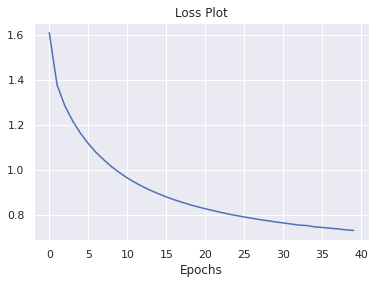

In [ ]:
# vocsize10K  200d 40epoch FULL DATASET
plt.plot(loss_plot)
plt.xlabel('Epochs')
plt.title('Loss Plot')
plt.show()

## Bleu

Παρακάτω έχουμε την υλοποίηση της μετρικής BLEU. Ο τρόπος που λειτουργεί χονδρικά αυτή η μετρική είναι συγκρίνοντας τα captions απο τα references με τα captions του hypothesis. Σε αυτά βρίσκει τα κοινά captions και ορίζει "βάρη" ανάλογα το πλήθος των κοινών captions. 

In [ ]:
"""BLEU score implementation."""

import math
import sys
import warnings
from collections import Counter
from fractions import Fraction

from nltk.util import ngrams


class SmoothingFunction:

    def __init__(self, epsilon=0.1, alpha=5, k=5):
        
        self.epsilon = epsilon
        self.alpha = alpha
        self.k = k
        
    def method1(self, p_n, *args, **kwargs):
        """
        Smoothing method 1: Add *epsilon* counts to precision with 0 counts.
        """
        return [
            (p_i.numerator + self.epsilon) / p_i.denominator
            if p_i.numerator == 0
            else p_i
            for p_i in p_n
        ]


def sentence_bleu(
    references,
    hypothesis,
    weights=(0.4, 0.3, 0.2, 0.1),
    smoothing_function= SmoothingFunction().method1,
    auto_reweigh=False,
):
    return corpus_bleu(
        [references], [hypothesis], weights, smoothing_function, auto_reweigh
    )

def corpus_bleu(
    list_of_references,
    hypotheses,
    weights=(0.4, 0.3, 0.2, 0.1),
    smoothing_function= SmoothingFunction().method1,
    auto_reweigh=False,
):

    # Before proceeding to compute BLEU, perform sanity checks.

    p_numerators = Counter()  # Key = ngram order, and value = no. of ngram matches.
    p_denominators = Counter()  # Key = ngram order, and value = no. of ngram in ref.
    hyp_lengths, ref_lengths = 0, 0

    assert len(list_of_references) == len(hypotheses), (
        "The number of hypotheses and their reference(s) should be the " "same "
    )

    try:
        weights[0][0]
    except TypeError:
        weights = [weights]
    max_weight_length = max(len(weight) for weight in weights)

    # Iterate through each hypothesis and their corresponding references.
    for references, hypothesis in zip(list_of_references, hypotheses):
        # For each order of ngram, calculate the numerator and
        # denominator for the corpus-level modified precision.
        for i in range(1, max_weight_length + 1):
            p_i = modified_precision(references, hypothesis, i)
            p_numerators[i] += p_i.numerator
            p_denominators[i] += p_i.denominator

        # Calculate the hypothesis length and the closest reference length.
        # Adds them to the corpus-level hypothesis and reference counts.
        hyp_len = len(hypothesis)
        hyp_lengths += hyp_len
        ref_lengths += closest_ref_length(references, hyp_len)

    # Calculate corpus-level brevity penalty.
    bp = brevity_penalty(ref_lengths, hyp_lengths)

    # Collects the various precision values for the different ngram orders.
    p_n = [
        Fraction(p_numerators[i], p_denominators[i], _normalize=False)
        for i in range(1, max_weight_length + 1)
    ]

    # Returns 0 if there's no matching n-grams
    # We only need to check for p_numerators[1] == 0, since if there's
    # no unigrams, there won't be any higher order ngrams.
    if p_numerators[1] == 0:
        return 0 if len(weights) == 1 else [0] * len(weights)

    # If there's no smoothing, set use method0 from SmoothinFunction class.
    if not smoothing_function:
        smoothing_function = SmoothingFunction().method0
    # Smoothen the modified precision.
    # Note: smoothing_function() may convert values into floats;
    #       it tries to retain the Fraction object as much as the
    #       smoothing method allows.
    p_n = smoothing_function(
        p_n, references=references, hypothesis=hypothesis, hyp_len=hyp_lengths
    )

    bleu_scores = []
    for weight in weights:
        # Uniformly re-weighting based on maximum hypothesis lengths if largest
        # order of n-grams < 4 and weights is set at default.
        if auto_reweigh:
            if hyp_lengths < 4 and weight == (0.25, 0.25, 0.25, 0.25):
                weight = (1 / hyp_lengths,) * hyp_lengths

        s = (w_i * math.log(p_i) for w_i, p_i in zip(weight, p_n) if p_i > 0)
        s = bp * math.exp(math.fsum(s))
        bleu_scores.append(s)
    return bleu_scores[0] if len(weights) == 1 else bleu_scores

In [ ]:
def modified_precision(references, hypothesis, n):
    
    # Extracts all ngrams in hypothesis
    # Set an empty Counter if hypothesis is empty.
    counts = Counter(ngrams(hypothesis, n)) if len(hypothesis) >= n else Counter()
    # Extract a union of references' counts.
    # max_counts = reduce(or_, [Counter(ngrams(ref, n)) for ref in references])
    max_counts = {}
    for reference in references:
        reference_counts = (
            Counter(ngrams(reference, n)) if len(reference) >= n else Counter()
        )
        for ngram in counts:
            max_counts[ngram] = max(max_counts.get(ngram, 0), reference_counts[ngram])

    # Assigns the intersection between hypothesis and references' counts.
    clipped_counts = {
        ngram: min(count, max_counts[ngram]) for ngram, count in counts.items()
    }

    numerator = sum(clipped_counts.values())
    # Ensures that denominator is minimum 1 to avoid ZeroDivisionError.
    # Usually this happens when the ngram order is > len(reference).
    denominator = max(1, sum(counts.values()))

    return Fraction(numerator, denominator, _normalize=False)


def closest_ref_length(references, hyp_len):
   
    ref_lens = (len(reference) for reference in references)
    closest_ref_len = min(
        ref_lens, key=lambda ref_len: (abs(ref_len - hyp_len), ref_len)
    )
    return closest_ref_len



def brevity_penalty(closest_ref_len, hyp_len):
    
    if hyp_len > closest_ref_len:
        return 1
    # If hypothesis is empty, brevity penalty = 0 should result in BLEU = 0.0
    elif hyp_len == 0:
        return 0
    else:
        return math.exp(1 - closest_ref_len / hyp_len)

## Caption!

* Η συνάρτηση αξιολόγησης είναι παρόμοια με τον βρόχο εκπαίδευσης, με τη διαφορά ότι δεν χρησιμοποιούμε την μέθοδο teacher forcing εδώ. Η είσοδος στον αποκωδικοποιητή σε κάθε χρονικό βήμα είναι οι προηγούμενες προβλέψεις του μαζί με την κρυφή κατάσταση και την έξοδο του κωδικοποιητή.
* Σταματάμε την πρόβλεψη όταν το μοντέλο προβλέπει το '<end>'.
* Και αποθηκεύουμε τα attention weights για κάθε χρονικό βήμα.

In [ ]:
def evaluate(image):
    #attention_plot = np.zeros((max_length, attention_features_shape))

    hidden = decoder.reset_state(batch_size=1)

    temp_input = tf.expand_dims(load_image(image)[0], 0)
    img_tensor_val = image_features_extract_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0],
                                                 -1,
                                                 img_tensor_val.shape[3]))

    features = encoder(img_tensor_val)

    dec_input = tf.expand_dims([word_to_index('<start>')], 0)
    result = []

    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input,
                                                         features,
                                                         hidden)

        #attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

        predicted_id = tf.random.categorical(predictions, 1)[0][0].numpy()   # beam search
        predicted_word = tf.compat.as_text(index_to_word(predicted_id).numpy())
        result.append(predicted_word)

        if predicted_word == '<end>':
            return result       #, attention_plot

        dec_input = tf.expand_dims([predicted_id], 0)

    #attention_plot = attention_plot[:len(result), :]
    return result           #, attention_plot

Prediction Caption (hypothesis): ['a', 'beautiful', 'picture', 'of', 'the', 'ocean', 'shirts', 'on', 'some', 'trees', 'going', 'into', 'the', 'background', 'of', 'dogs', 'cross']
Real Caption (references): ['people', 'sitting', 'near', 'water', 'overseeing', 'the', 'buildings']
Bleu Score for the 4489 extracted sample: 0.015730893153349367


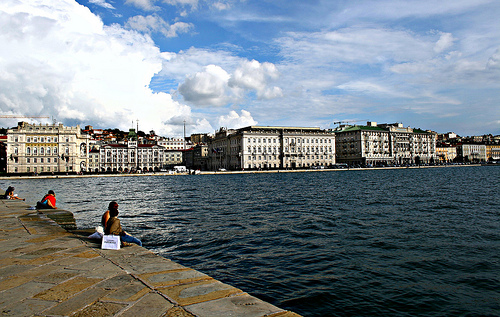

In [ ]:
rapper_words = ["<start>", ".", "<end>"]

rid = 4489
image = img_name_val[rid]
r1 = evaluate(image)
result = [word for word in r1 if word not in list(rapper_words)]
r2 = [tf.compat.as_text(index_to_word(i).numpy()) for i in cap_val[rid] if i not in [0]]
real_caption = [word for word in r2 if word not in list(rapper_words)]

print('Prediction Caption (hypothesis):', result)
print('Real Caption (references):', real_caption)
print('Bleu Score for the', rid, 'extracted sample:', corpus_bleu([real_caption], [result]))
Image.open(img_name_val[rid])

Prediction Caption (hypothesis): ['a', 'bicyclist', 'riding', 'a', 'bicycle']
Real Caption (references): ['two', 'bikers', 'with', 'people', 'in', 'the', 'background', 'waiting', 'in', 'line']
Bleu Score for the 19899 extracted sample: 0.06520287571944944


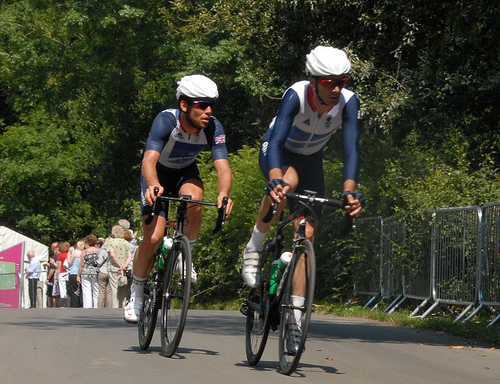

In [ ]:
rapper_words = ["<start>", ".", "<end>"]

rid = 19899
image = img_name_val[rid]
r1 = evaluate(image)
result = [word for word in r1 if word not in list(rapper_words)]
r2 = [tf.compat.as_text(index_to_word(i).numpy()) for i in cap_val[rid] if i not in [0]]
real_caption = [word for word in r2 if word not in list(rapper_words)]

print('Prediction Caption (hypothesis):', result)
print('Real Caption (references):', real_caption)
print('Bleu Score for the', rid, 'extracted sample:', corpus_bleu([real_caption], [result]))
Image.open(img_name_val[rid])

In [ ]:
rapper_words = ["<start>", ".", "<end>"]

hypothesis = []
references = []
for rid in tqdm(range(0, len(img_name_val))):
  image = img_name_val[rid]
  r1 = evaluate(image)
  result = [word for word in r1 if word not in list(rapper_words)]
  hypothesis.append(result)
  r2 = [tf.compat.as_text(index_to_word(i).numpy()) for i in cap_val[rid] if i not in [0]]
  real_caption = [word for word in r2 if word not in list(rapper_words)]
  references.append(real_caption)

joblib.dump(references, '/content/drive/My Drive/ece/NN/lab3/references_Emb6B200_vocsize10K_full.pkl')
joblib.dump(hypothesis, '/content/drive/My Drive/ece/NN/lab3/hypothesis_Emb6B200_vocsize10K_full.pkl')

100%|██████████| 29412/29412 [7:31:34<00:00,  1.09it/s]


['/content/drive/My Drive/ece/NN/lab3/hypothesis_Emb6B200_vocsize10K_full.pkl']

Total Bleu Score: 4.283303629216624e-05

Prediction Caption (hypothesis): ['a', 'long-haired', 'man', 'falling', 'asleep', 'in', 'a', 'park']
Real Caption (references): ['a', 'man', 'wearing', 'a', 'dark', 'top', 'and', 'white', 'pants', 'lies', 'down', 'in', 'the', 'shade', 'on', 'park', 'bench']


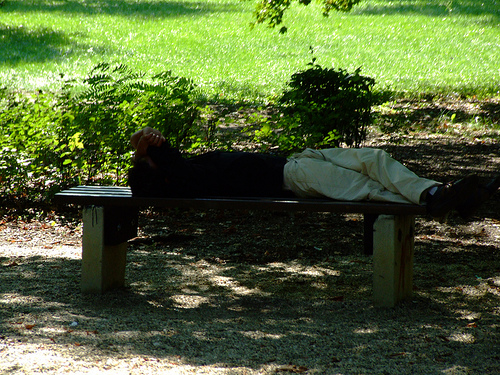

In [ ]:
print('Total Bleu Score:', corpus_bleu(references, hypothesis))
print("")
print('Prediction Caption (hypothesis):', hypothesis[108])
print('Real Caption (references):', references[108])
Image.open(img_name_val[108])

# Αξιολόγηση αποτελεσμάτων 
Για να αποφασίσουμε τις βελτιστοποιήσεις που επιλέξαμε έγιναν αρκετές δοκιμές. Αρχικά δοκιμάσαμε τιμές στο `vocabulary_size` από 7.000 μέχρι 10.000 και παρατηρήσαμε καλύτερα αποτελέσματα σε μεγάλα λεξικά. Έπειτα για τις διαστάσεις των word embeddings `glove.6B` (που συμπεριλαμβάνουν το `glove-wiki`) πειραματιστήκαμε με dimension από 50 εως 300 και αποφασίσαμε πως 200d είναι μία ικανοποιητική παράμετρος. Και τέλος στον decoder βάλαμε LSTM αντί για GRU. 

Γνωρίζουμε πως δεν εχει υλοποιηθει/χρησιμοποιηθεί η $beam search$ αλλά έχει διατηρηθεί η $random$ ωστόσο το μεγαλύτερο κομμάτι της εργασίας ήταν έτοιμο πριν την παράταση της Καθαράς Δευτέρας και μετά από αυτήν μας έχει ταλαιπωρήσει η γρίπη. Ελπίζω να μην μας εχει στερήσει πολύ.

### Vocabulary 8K / No Embeddings / Epochs 40
Αρχικά ακολουθήσαμε το tutorial κατα γράμμα φορτώνοντας τα δεδομένα που μας παρότριναν στο εργαστήριο. Οπότε και δοκιμάσαμε εκπαίδευση με λίγο μεγαλύτερο vocabulary από 5Κ λέξεις. 

>Ενώ η εκπαίδευση πήγε καλά, με $loss < 0.3$ στις 40 εποχές, τα αποτελέσματα στα caption δεν ήταν εντυπωσιακά. 

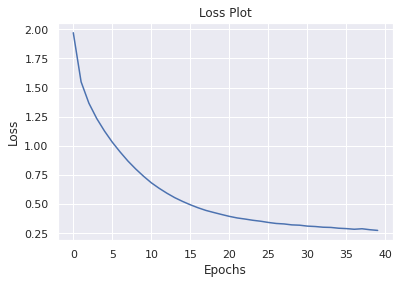

In [ ]:
# vocsize8K no embeddings 40epoch 
plt.plot(loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()

In [ ]:
print('Prediction Caption (hypothesis):', result)
print('Real Caption (references):', real_caption)

Prediction Caption (hypothesis): ['a', 'man', 'and', 'a', 'man', 'and', 'woman', 'are', 'standing', 'in', 'front', 'of', 'a', 'radio', 'and', 'wires', 'gathered', '<end>']
Real Caption (references): ['an', 'asian', 'man', 'is', 'standing', 'on', 'a', 'busy', 'sidewalk', 'as', 'people', 'walk', 'by', 'with', 'bags', '<end>']


### Vocabulary 7K / glove.6B - dim 100 / Epochs 40
Κατεβάσαμε τα word embeddings και κάναμε τους απαραίτητους μετασχηματισμούς. Με διαστάσεις 50 έγιναν δοκιμές όμως ήταν εξίσου απαιτητικές σε χρόνο και δεν έφεραν ικανοποιητικά αποτελέσματα. Όσον αφορά τα caption δεν έβγαζαν νόημα οι προτάσεις, ασχετα με τις εποχές εκπαίδευσης. 


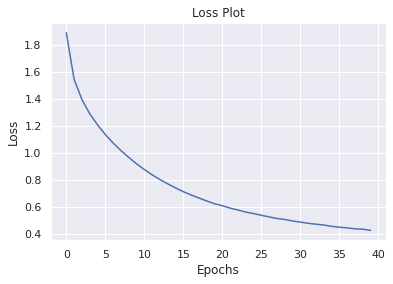

In [ ]:
plt.plot(loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()

Prediction Caption (hypothesis): ['two', 'friends', 'catch', 'a', 'man', 'next', 'to', 'a', 'group', 'of', 'friends', 'but', 'is', 'being', 'placed', 'in', 'front', 'of', 'a', 'black', 'chair']
Real Caption (references): ['a', 'man', 'is', 'juggling', 'tennis', 'balls', 'next', 'to', 'his', 'two', 'friends']
Bleu Score from the first 5938 extracted samples: 0.0001125790141152167


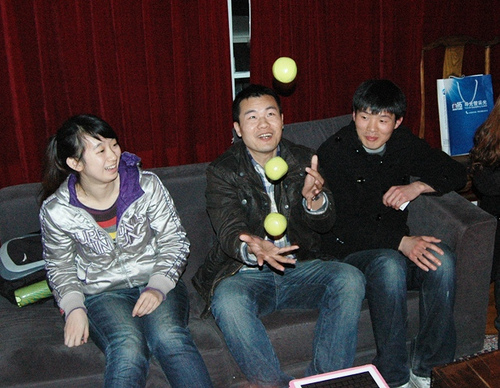

In [ ]:
print('Prediction Caption (hypothesis):', hypothesis[108])
print('Real Caption (references):', references[108])
print('Bleu Score from the first', rid, 'extracted samples:', corpus_bleu(references, hypothesis))
Image.open(img_name_val[108])

### Vocabulary 7K / glove.6B - dim 200 / Epochs 20
Δοκιμάσαμε να αυξήσουμε ξανα το dimension και αφου είδαμε σημαντική βελτίωση στο $Loss Plot$ προχωρήσαμε σε επόμενες βελτιώσεις.
 
Ωστόσο στην συγκεκριμένη προσπάθεια αξίζει να παρατηρήσουμε:
 
* Ήδη στις 20 εποχές το $loss$ έχει πέσει κάτω από το $0,6$.
* Τα caption ποιοτικά δεν βγάζουν νόημα ούτε ως πρόταση.
* $Total Bleu Score = 0,0001145$

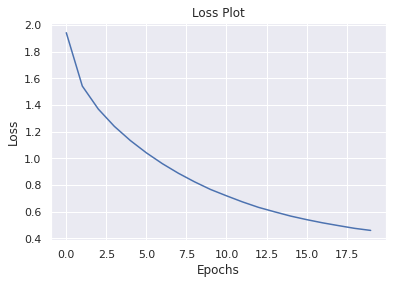

In [ ]:
# vocsize7K 200d 20epoch
plt.plot(loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()

Prediction Caption (hypothesis): ['a', 'group', 'of', 'people', 'sitting', 'on', 'his', 'type', 'of', 'makeup', 'on', 'his', 'last', 'head', 'in', 'his', 'arms', 'inside', 'reading', 'in', 'his', 'hands', 'on', 'his', 'type']
Real Caption (references): ['three', 'african', 'children', 'sitting', 'in', 'a', 'bamboo', 'tent']
Bleu Score from the first 5942 extracted samples: 0.0001145065917524179


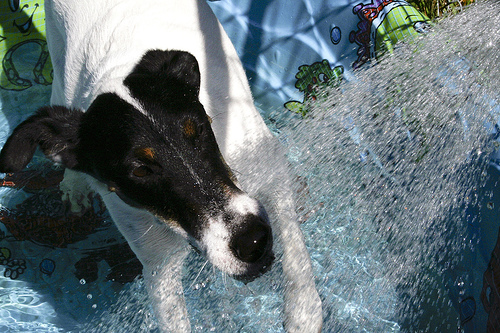

In [ ]:
print('Prediction Caption (hypothesis):', result)
print('Real Caption (references):', real_caption)
print('Bleu Score from the first', rid, 'extracted samples:', corpus_bleu(references, hypothesis))
Image.open(img_vect[rid])

### Vocabulary 10K / glove.6B - dim 200 / Epochs 45

Αυξήσαμε το μέγεθος του λεξιλογίου και εκπαιδεύσαμε το δίκτυο μας για παραπάνω εποχές. <br> Επίσης βάλαμε να τυπώνεται πιο τακτικά το score για να παρατηρούμε την εξέλιξη. 

Αξίζει να σημειωθεί ότι: 

* Στις 45 εποχές έχουμε $loss< 0,4$. 
* Τα caption ποιοτικά έχουν αρχίσει να βγάζουν νόημα, αν και δεν είναι απόλυτα ορθά. 
* Κάποια $Bleu Score$ σε συγκεκριμένες προτάσεις που αξιολογήσαμε ήταν $0,016784$ και $0,022934$. 
* $Total Bleu Score = 0,0001130$ 

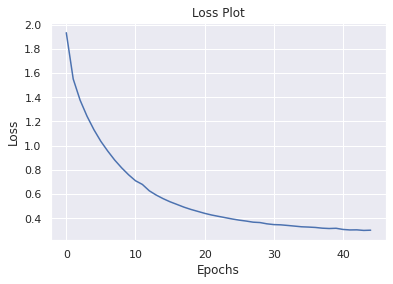

In [ ]:
# vocsize10K  200d 45epoch
plt.plot(loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()

Prediction Caption (hypothesis): ['a', 'crowd', 'of', 'people', 'are', 'having', 'a', 'crowd', 'watching', 'a', 'food', 'station']
Real Caption (references): ['people', 'walking', 'around', 'looking', 'at', 'furniture']
Bleu Score from the first 289 extracted samples: 0.022934297673382436


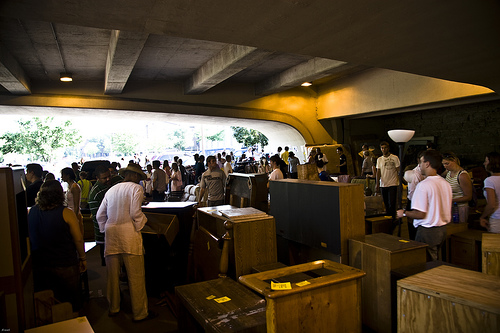

In [ ]:
rapper_words = ["<start>", ".", "<end>"]

rid = 289
image = img_name_val[rid]
r1 = evaluate(image)
result = [word for word in r1 if word not in list(rapper_words)]
r2 = [tf.compat.as_text(index_to_word(i).numpy()) for i in cap_val[rid] if i not in [0]]
real_caption = [word for word in r2 if word not in list(rapper_words)]

print('Prediction Caption (hypothesis):', result)
print('Real Caption (references):', real_caption)
print('Bleu Score from the first', rid, 'extracted samples:', corpus_bleu([real_caption], [result]))
Image.open(img_name_val[rid])

In [ ]:
rapper_words = ["<start>", ".", "<end>"]

hypothesis = []
references = []
for rid in tqdm(range(0, len(img_name_val))):
  image = img_name_val[rid]
  r1 = evaluate(image)
  result = [word for word in r1 if word not in list(rapper_words)]
  hypothesis.append(result)
  r2 = [tf.compat.as_text(index_to_word(i).numpy()) for i in cap_val[rid] if i not in [0]]
  real_caption = [word for word in r2 if word not in list(rapper_words)]
  references.append(real_caption)
  # print the bleu score
  if rid%1000==0 : 
      print('\n Bleu Score from the first', rid, 'extracted samples:', corpus_bleu(references, hypothesis))
    
    
print('Prediction Caption (hypothesis):', result)
print('Real Caption (references):', real_caption)
print('Bleu Score from the first', rid, 'extracted samples:', corpus_bleu(references, hypothesis))

# Save the files for useing them i
joblib.dump(references, '/content/drive/My Drive/ece/NN/lab3/references_Emb6B200_last_vocsize10K.pkl')
joblib.dump(hypothesis, '/content/drive/My Drive/ece/NN/lab3/hypothesis_Emb6B200_last_vocsize10K.pkl')

  0%|          | 1/5905 [00:01<2:36:00,  1.59s/it]


 Bleu Score from the first 0 extracted samples: 0.016784356170933493


 17%|█▋        | 1001/5905 [14:56<1:33:52,  1.15s/it]


 Bleu Score from the first 1000 extracted samples: 0.0003285153558263506


 34%|███▍      | 2000/5905 [29:34<1:05:55,  1.01s/it]


 Bleu Score from the first 2000 extracted samples: 0.0002177709688322174


 51%|█████     | 3000/5905 [44:18<46:13,  1.05it/s]


 Bleu Score from the first 3000 extracted samples: 0.00017019803023392052


 68%|██████▊   | 4000/5905 [59:15<29:47,  1.07it/s]


 Bleu Score from the first 4000 extracted samples: 0.00014206715231789217


 85%|████████▍ | 5000/5905 [1:14:09<12:22,  1.22it/s]


 Bleu Score from the first 5000 extracted samples: 0.00012415921828032406


100%|██████████| 5905/5905 [1:27:32<00:00,  1.12it/s]


Prediction Caption (hypothesis): ['a', 'male', 'in', 'black', 'jersey', 'throwing', 'a', 'blue', 'ball', ',', 'the', 'kids', 'play', 'a', 'blue', 'ball']
Real Caption (references): ['a', 'girl', 'in', 'a', 'pink', 'shirt', 'is', 'throwing', 'a', 'football']
Bleu Score from the first 5904 extracted samples: 0.00011297498885359672


['/content/drive/My Drive/ece/NN/lab3/hypothesis_Emb6B200_last_vocsize10K.pkl']

### Vocabulary 10K / glove.6B - dim 200 / Epochs 50 

***Αντικαταστήσαμε τις μονάδες GRU με LSTM***

Παρατηρήσεις: 

* Στις 50 εποχές έχουμε $loss< 0,3$. 
* Κάποια $Bleu Score$ σε συγκεκριμένες προτάσεις που αξιολογήσαμε ήταν $0,042512379$ και $0,05139541$. 
* $Total Bleu Score =  0,0001177$ 

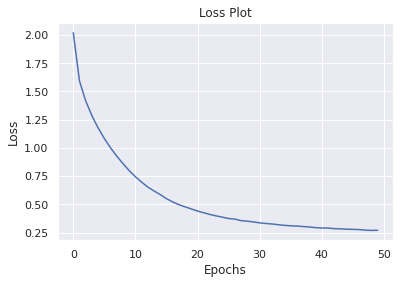

In [ ]:
# vocsize10K  200d 50epoch LSTM
plt.plot(loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()

Prediction Caption (hypothesis): ['an', 'elderly', 'woman', 'is', 'putting', 'a', 'drum']
Real Caption (references): ['a', 'man', 'sculpts', 'a', 'hot', 'piece', 'of', 'metal']
Bleu Score from the first 1756 extracted samples: 0.042512379003774886


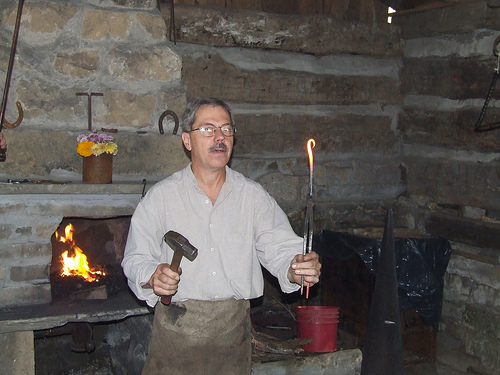

In [ ]:
rapper_words = ["<start>", ".", "<end>"]

rid = 1756
image = img_name_val[rid]
r1 = evaluate(image)
result = [word for word in r1 if word not in list(rapper_words)]
r2 = [tf.compat.as_text(index_to_word(i).numpy()) for i in cap_val[rid] if i not in [0]]
real_caption = [word for word in r2 if word not in list(rapper_words)]

print('Prediction Caption (hypothesis):', result)
print('Real Caption (references):', real_caption)
print('Bleu Score from the first', rid, 'extracted samples:', corpus_bleu([real_caption], [result]))
# Bleu Score for the 1756 extracted sample:   # Διόρθωση
Image.open(img_name_val[rid])

Prediction Caption (hypothesis): ['a', 'person', 'is', 'climbing', 'a', 'mountain']
Real Caption (references): ['hiker', 'climbing', 'down', 'a', 'snow', 'and', 'rock', 'covered', 'mountain']
Bleu Score from the first 2899 extracted samples: 0.05139541471864835


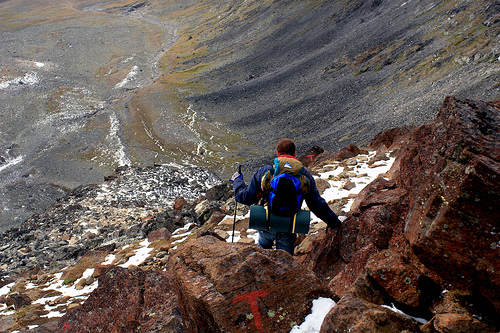

In [ ]:
rapper_words = ["<start>", ".", "<end>"]

rid = 2899
image = img_name_val[rid]
r1 = evaluate(image)
result = [word for word in r1 if word not in list(rapper_words)]
r2 = [tf.compat.as_text(index_to_word(i).numpy()) for i in cap_val[rid] if i not in [0]]
real_caption = [word for word in r2 if word not in list(rapper_words)]

print('Prediction Caption (hypothesis):', result)
print('Real Caption (references):', real_caption)
print('Bleu Score from the first', rid, 'extracted samples:', corpus_bleu([real_caption], [result]))
# Bleu Score for the 2899 extracted sample:   # Διόρθωση
Image.open(img_name_val[rid])

Total Bleu Score: 0.00011771707631572266

Prediction Caption (hypothesis): ['a', 'man', 'is', 'cutting', 'together', 'and', 'a', 'beard', 'and', 'a', 'white', 'shirt', 'is', 'in', 'a', 'blue', 'shirt', 'is', 'bouncing', 'his', 'fish']
Real Caption (references): ['a', 'man', 'in', 'a', 'plaid', 'shirt', 'is', 'throwing', 'a', 'hatchet', 'at', 'a', 'wall', 'in', 'his', 'garage']


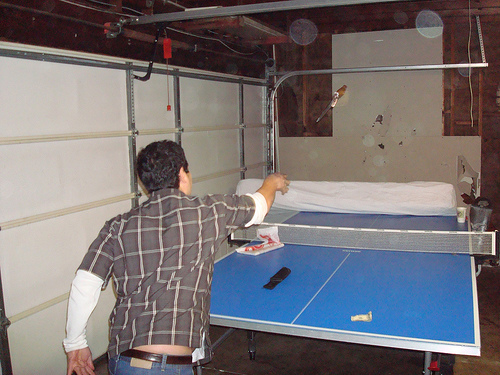

In [ ]:
print('Total Bleu Score:', corpus_bleu(references, hypothesis))
print("")
print('Prediction Caption (hypothesis):', hypothesis[108])
print('Real Caption (references):', references[108])
Image.open(img_name_val[108])

## Αξιολόγηση αποτελεσμάτων με εκπαίδευση του πλήρης dataset. 
Σε όλα τα παραπάνω δείγματα έχουμε χρησιμοποιήσει ένα μέρος του dataset για να μπορούμε να συγκρίνουμε τις μετρικές και παραμέτρους μεταξύ τους και να εξοικονομήσουμε χρόνο. Το Notebook είναι από το τελικό run και το πλήρες dataset. Εδώ με την εκπαίδευση το $loss$ δεν έπεσε κάτω από $0,5$ καθώς οι 40 εποχές που τρέξαμε μας πήραν ήδη 6 ώρες και σε ποιοτικό επίπεδο τα caption ήταν ήδη πολύ καλύτερα από άλλες προσπάθειες με 40 και 50 εποχές. 

<h3>$Τελικό Bleu Score =  0,00004 $</h3>
Είναι λογικό πως όσο περισσότερα τα δείγματα τόσο πιο δύσκολα ανεβαίνει το bleu score. Όμως βλέπουμε πως από ποιοτικής άποψης οι προβλέψεις είναι πολύ κοντά στις απεικονίσεις. 

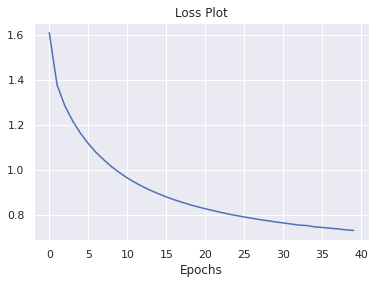

In [ ]:
# vocsize10K  200d 40epoch FULL DATASET
plt.plot(loss_plot)
plt.xlabel('Epochs')
plt.title('Loss Plot')
plt.show()

Prediction Caption (hypothesis): ['a', 'man', 'in', 'boots', 'with', 'a', 'ladder']
Real Caption (references): ['an', 'old', 'man', 'is', 'walking', 'in', 'bad', 'weather']
Bleu Score from the first 2899 extracted samples: 0.042512379003774886


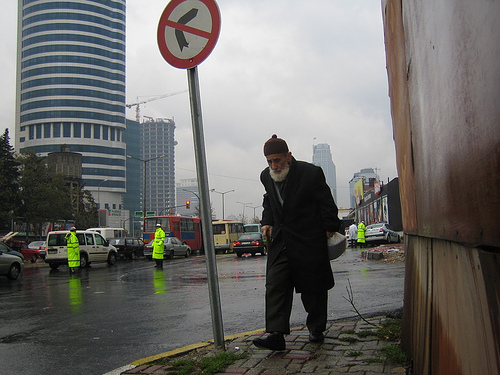

In [ ]:
rapper_words = ["<start>", ".", "<end>"]

rid = 2899
image = img_name_val[rid]
r1 = evaluate(image)
result = [word for word in r1 if word not in list(rapper_words)]
r2 = [tf.compat.as_text(index_to_word(i).numpy()) for i in cap_val[rid] if i not in [0]]
real_caption = [word for word in r2 if word not in list(rapper_words)]

print('Prediction Caption (hypothesis):', result)
print('Real Caption (references):', real_caption)
print('Bleu Score from the first', rid, 'extracted samples:', corpus_bleu([real_caption], [result]))
# Bleu Score for the 2899 extracted sample:   # Διόρθωση
Image.open(img_name_val[rid])

In [ ]:
print('Total Bleu Score:', corpus_bleu(references, hypothesis))

Total Bleu Score: 4.283303629216624e-05
